In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/BrainTumourTraining(Dataset1).zip" -d /content/

In [ ]:
!pip install timm # provides collection of cv models, optimisers and other utilities


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import copy
import os
import json
from datetime import datetime

In [ ]:
#define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Mean computed from imageNet Datasaset
                         [0.229, 0.224, 0.225])   # Std deviation computed from imageNet Dataset
])

#Every image from the dataset will sequentially go through these 3 transformations

In [ ]:
#load dataset
dataset = datasets.ImageFolder('/content/BrainTumourTraining(Dataset1)', transform=transform)
class_names = dataset.classes
print(class_names)
print(f"Number of training samples: {len(dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


['glioma', 'meningioma', 'notumor', 'pituitary']
Number of training samples: 5712
Number of testing samples: 4401


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def create_model():
    """Create and return a fresh model instance"""
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 4)
    return model.to(device)


## Training Loop

In [ ]:
def train_fold(model, train_loader, val_loader, epochs=5, lr=3e-5):
    """Train model for one fold"""
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.2]).to(device)
    loss_func = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_accuracies

In [ ]:
def evaluate_model(model, test_loader, class_names, device, fold_num=None):
    """Evaluate model and return predictions, labels, and probabilities"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

    if fold_num is not None:
        print(f"\nFold {fold_num} Results:")
        print("="*30)
    else:
        print(f"\nTest Set Results:")
        print("="*30)

    print(f"Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return np.array(all_preds), np.array(all_labels), np.array(all_probs), accuracy


In [ ]:
def plot_confusion_matrix(labels, preds, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Cross-Validation Setup
def cross_validation(dataset, k_folds=5, epochs=5, batch_size=32, lr=3e-5):
    """Perform k-fold cross validation"""
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    cv_results = {
        'fold_accuracies': [],
        'fold_predictions': [],
        'fold_labels': [],
        'fold_probabilities': [],
        'train_losses_per_fold': [],
        'val_accuracies_per_fold': []
    }

    # Get indices for cross-validation
    dataset_indices = list(range(len(dataset)))

    print(f"Starting {k_folds}-Fold Cross Validation")
    print("="*50)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset_indices)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 30)

        # Create data subsets for this fold
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Create fresh model for this fold
        model = create_model()

        # Train the model
        train_losses, val_accuracies = train_fold(model, train_loader, val_loader, epochs, lr)

        # Evaluate on validation set
        preds, labels, probs, accuracy = evaluate_model(model, val_loader, class_names, device, fold + 1)

        # Store results
        cv_results['fold_accuracies'].append(accuracy)
        cv_results['fold_predictions'].append(preds)
        cv_results['fold_labels'].append(labels)
        cv_results['fold_probabilities'].append(probs)
        cv_results['train_losses_per_fold'].append(train_losses)
        cv_results['val_accuracies_per_fold'].append(val_accuracies)

    return cv_results


In [ ]:
def analyze_cv_results(cv_results, class_names):
    """Analyze and visualize cross-validation results"""
    fold_accuracies = cv_results['fold_accuracies']

    print(f"\nCross-Validation Results Summary")
    print("="*50)
    print(f"Mean Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}%")
    print(f"Min Accuracy: {np.min(fold_accuracies):.2f}%")
    print(f"Max Accuracy: {np.max(fold_accuracies):.2f}%")

    # Plot accuracy across folds
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(fold_accuracies) + 1), fold_accuracies)
    plt.axhline(y=np.mean(fold_accuracies), color='r', linestyle='--',
                label=f'Mean: {np.mean(fold_accuracies):.2f}%')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Across Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot training curves
    plt.subplot(1, 2, 2)
    for i, (train_losses, val_accs) in enumerate(zip(cv_results['train_losses_per_fold'],
                                                    cv_results['val_accuracies_per_fold'])):
        plt.plot(val_accs, alpha=0.7, label=f'Fold {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Aggregate confusion matrix
    all_preds = np.concatenate(cv_results['fold_predictions'])
    all_labels = np.concatenate(cv_results['fold_labels'])
    plot_confusion_matrix(all_labels, all_preds, class_names,
                         title="Aggregated Confusion Matrix (Cross-Validation)")

In [ ]:
def train_final_model_and_test(dataset, test_dataset, class_names, epochs=5, batch_size=32, lr=3e-5):
    """Train final model on full training set and evaluate on test set"""
    print(f"\nTraining Final Model on Full Training Set")
    print("="*50)

    # Use 90% for training, 10% for validation
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create and train final model
    final_model = create_model()
    train_losses, val_accuracies = train_fold(final_model, train_loader, val_loader, epochs, lr)

    # Evaluate on test set
    print(f"\nFinal Test Set Evaluation:")
    test_preds, test_labels, test_probs, test_accuracy = evaluate_model(
        final_model, test_loader, class_names, device)

    # Plot final confusion matrix
    plot_confusion_matrix(test_labels, test_preds, class_names,
                         title="Final Test Set Confusion Matrix")

    return final_model, test_accuracy


Starting 5-Fold Cross Validation

Fold 1/5
------------------------------


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5 - Train Loss: 0.3081, Val Acc: 95.80%
Epoch 2/5 - Train Loss: 0.0504, Val Acc: 94.05%
Epoch 3/5 - Train Loss: 0.0299, Val Acc: 97.55%
Epoch 4/5 - Train Loss: 0.0236, Val Acc: 97.03%
Epoch 5/5 - Train Loss: 0.0258, Val Acc: 97.90%

Fold 1 Results:
Accuracy: 97.90%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       288
  meningioma       0.97      0.95      0.96       265
     notumor       0.98      1.00      0.99       291
   pituitary       0.99      0.98      0.98       299

    accuracy                           0.98      1143
   macro avg       0.98      0.98      0.98      1143
weighted avg       0.98      0.98      0.98      1143


Fold 2/5
------------------------------
Epoch 1/5 - Train Loss: 0.3446, Val Acc: 95.45%
Epoch 2/5 - Train Loss: 0.0600, Val Acc: 97.73%
Epoch 3/5 - Train Loss: 0.0219, Val Acc: 95.98%
Epoch 4/5 - Train Loss: 0.0258, Val Acc: 97.38%
Epoch 5/5 - Train Loss: 0.0097, Va

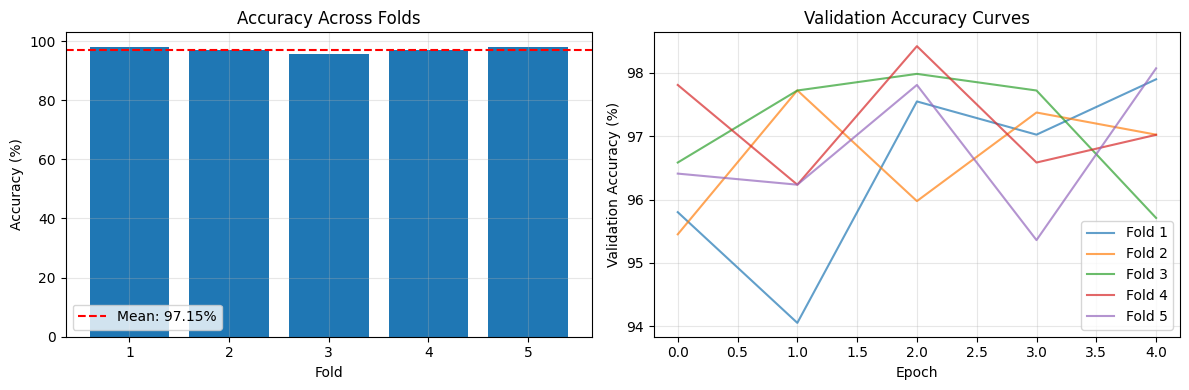

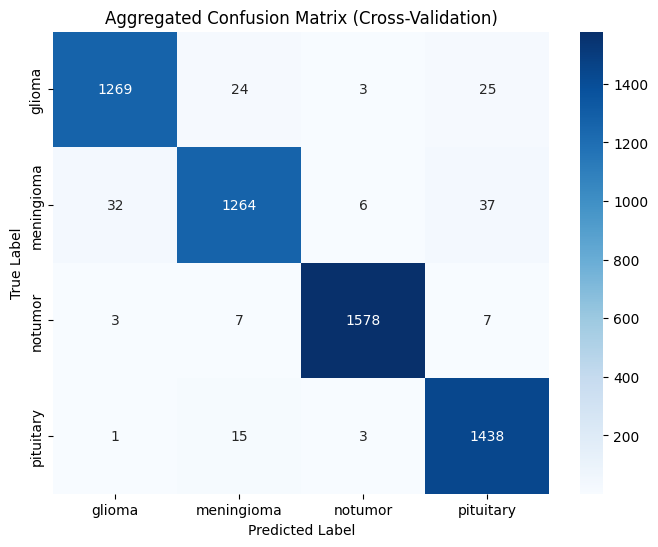


Training Final Model on Full Training Set
Epoch 1/5 - Train Loss: 0.2662, Val Acc: 96.50%
Epoch 2/5 - Train Loss: 0.0554, Val Acc: 96.50%
Epoch 3/5 - Train Loss: 0.0175, Val Acc: 98.43%
Epoch 4/5 - Train Loss: 0.0240, Val Acc: 96.33%
Epoch 5/5 - Train Loss: 0.0303, Val Acc: 97.73%

Final Test Set Evaluation:

Test Set Results:
Accuracy: 98.80%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       672
  meningioma       0.97      1.00      0.98      1100
     notumor       1.00      0.98      0.99      2000
   pituitary       0.99      0.99      0.99       629

    accuracy                           0.99      4401
   macro avg       0.99      0.99      0.99      4401
weighted avg       0.99      0.99      0.99      4401



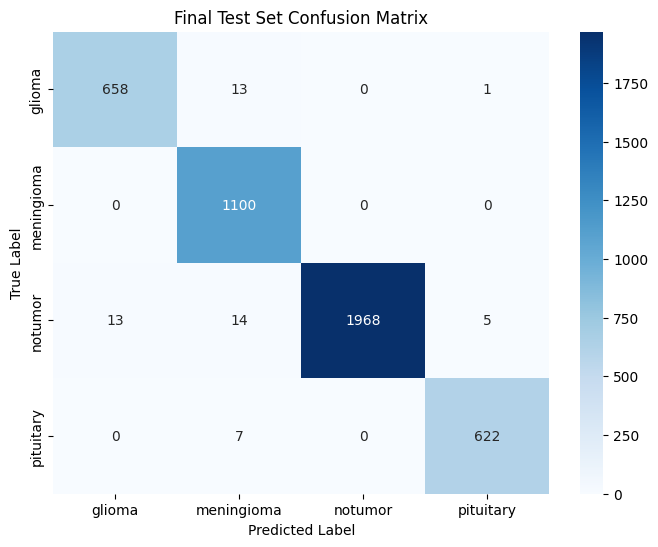


Summary:
Cross-Validation Mean Accuracy: 97.15% ± 0.84%
Final Test Set Accuracy: 98.80%


In [ ]:
# Hyperparameters
K_FOLDS = 5
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 3e-5

# Perform cross-validation
cv_results = cross_validation(dataset, k_folds=K_FOLDS, epochs=EPOCHS,
                                 batch_size=BATCH_SIZE, lr=LEARNING_RATE)

# Analyze results
analyze_cv_results(cv_results, class_names)

# Train final model and test
final_model, test_accuracy = train_final_model_and_test(
                              dataset, test_dataset, class_names, epochs=EPOCHS,
                              batch_size=BATCH_SIZE, lr=LEARNING_RATE)

#save model to drive
torch.save(final_model.state_dict(), '/content/drive/MyDrive/vit_brain_tumor_v2.pth')

print(f"\nSummary:")
print("="*50)
print(f"Cross-Validation Mean Accuracy: {np.mean(cv_results['fold_accuracies']):.2f}% ± {np.std(cv_results['fold_accuracies']):.2f}%")
print(f"Final Test Set Accuracy: {test_accuracy:.2f}%")

# Evaluate model on seperate dataset

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import timm
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix

!unzip "/content/drive/MyDrive/BrainTumourTesting(Dataset2).zip" -d /content/





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/BrainTumourTesting(Dataset2).zip
replace /content/BrainTumourTesting(Dataset2)/glioma/glioma (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: === DIAGNOSTIC INFO ===
CUDA available: False
Device: cpu
Model device: cpu
Model training mode: False
Total parameters: 85,801,732


In [16]:
print("=== DIAGNOSTIC INFO ===")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model architecture
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = torch.nn.Linear(model.head.in_features, 4)

# Load the saved weights
model.load_state_dict(torch.load('/content/drive/MyDrive/vit_brain_tumor_v2.pth', map_location=device))
model = model.to(device)
model.eval()

print(f"Model device: {next(model.parameters()).device}")
print(f"Model training mode: {model.training}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

=== DIAGNOSTIC INFO ===
CUDA available: False
Device: cpu
Model device: cpu
Model training mode: False
Total parameters: 85,801,732


In [ ]:
# Load test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('/content/BrainTumourTesting(Dataset2)', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes

print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches: {len(test_loader)}")
print(f"Batch size: {test_loader.batch_size}")
print(f"Classes: {class_names}")

**Perform Transform
**

In [ ]:
# Test single batch timing
print("\n=== SINGLE BATCH TEST ===")
with torch.no_grad():
    start = time.time()
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    end = time.time()
    print(f"Single batch ({inputs.shape[0]} images) processing time: {end-start:.2f}s")

print("\n=== FULL EVALUATION ===")
model.eval()
all_preds = []
all_labels = []
all_probs = []

start_time = time.time()
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        batch_start = time.time()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        batch_time = time.time() - batch_start

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_loader)}: {batch_time:.2f}s")

        # Early exit for testing (remove this after confirming it works)
        if batch_idx >= 5:  # Process only first 6 batches for testing
            print("Early exit for testing...")
            break

total_time = time.time() - start_time
print(f"Total processing time: {total_time:.2f}s")

# Calculate metrics AFTER processing all batches
accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f"Accuracy (partial): {accuracy:.2f}%")

print("Classes in predictions:", np.unique(all_preds))
print("Classes in labels:", np.unique(all_labels))


KeyboardInterrupt: 

In [ ]:
print("\n=== FULL EVALUATION (OPTIMIZED) ===")
def evaluate_model_optimized(model, test_loader, class_names, device):
    """Optimized evaluation function"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    print(f"Processing {len(test_loader)} batches...")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            # Move to device
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Collect results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Progress indicator
            if batch_idx % 20 == 0:
                print(f"Progress: {batch_idx}/{len(test_loader)} batches")

    # Calculate final metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy = np.mean(all_preds == all_labels) * 100

    print(f"\nFinal Results:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Total samples: {len(all_labels)}")
    print(f"Classes found in predictions: {np.unique(all_preds)}")
    print(f"Classes found in labels: {np.unique(all_labels)}")

    print("\nClassification Report:")
    try:
        print(classification_report(all_labels, all_preds, target_names=class_names))
    except ValueError as e:
        print(f"Classification report error: {e}")
        print("Using label indices instead:")
        print(classification_report(all_labels, all_preds))

    return all_preds, all_labels, all_probs, accuracy

preds, labels, probs, acc = evaluate_model_optimized(model, test_loader, class_names, device)

# Final Verdict:
> In the most of the runs , the model produced 97% accuracy for splitted unseen data from same dataset, And **95%** accuracy in completely Seperate Dataset.

> The model achieved **94 to 96% accuracy** on a completely separate testing dataset collected from a different source, indicating strong generalization.



> High caution was taken to ensure that the training and testing datasets were collected from completely separate and independently referenced sources.


 This high performance is likely due to the pretrained ViT model and consistent preprocessing, with no overlap or data leakage between training and testing sets.
